## Dependencies

In [29]:
import sys
import os
root_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root_dir)
from pathlib import Path

import torch
from PIL import Image


from models import tiramisu_nclasses
import src.training as train_utils
from src.imgs import ImgToolkit
from src import tools


from datasets.inference_dataset import InferenceDataset
from datasets.floodnet import Dataset

import time

In [22]:
base_mem, one_img = 3.5, 3 # GB 
input_device = 'gpu' # 'gpu' 'auto'

output_folder = '/outputs/airflow_data/outputs'



output_folder = Path(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)
tools.total_mem(), tools.free_mem(), tools.mem()

((125.79545593261719, 14.56805419921875),
 (119.7257080078125, 14.351417064666748),
 (4.408252716064453, 0.21663713455200195))

In [23]:
def gpu_index(mem):
    gpu_mem = mem[1:]
    print(gpu_mem)
    return  max(range(len(gpu_mem)), key=lambda i: gpu_mem[i])+1


def set_device(input_device, mem):
    
    if (input_device == 'cpu') or len(mem) == 1: 
        return torch.device('cpu'), int(mem[0] // one_img)
    elif input_device in ('gpu', 'auto'):
        if len(mem) == 1:
            print("no gpu found, using cpu")
            return torch.device('cpu'), int(mem[0] // one_img)
        else:
            i = gpu_index(mem)
            print(i, mem)
            return torch.device(f'cuda:{i-1}'), int(mem[i] // one_img)

def save_segmentation_mask(tensor, path):
    array = tensor.cpu().numpy().astype('uint8')
    img = Image.fromarray(array, mode='L')  # 'L' = 8-bit grayscale
    img.save(path)
    

In [24]:

mems = tools.free_mem()

device, batch_size = set_device(input_device, mems)

print(device, batch_size)


(14.351417064666748,)
1 (119.72730255126953, 14.351417064666748)
cuda:0 4


In [25]:
# dataset_folder='/outputs/RescueNet-resized-713/semanticSegmentationTestSet/test-org-img'
dataset_folder='/outputs/airflow_data/floodnet/img-4000'
dataset_folder='/outputs/airflow_data/floodnet/img-700'
infererence_dataset = InferenceDataset(Dataset_model=Dataset, dataset_folder=dataset_folder)
len(infererence_dataset)

383

In [26]:
imgt = ImgToolkit(infererence_dataset)


In [27]:
# weights_file = Path(root_dir) / '.weights' / 'adam_sched' / 'weights-395.pth'
weights_file = Path(root_dir) / '.weights' / 'fn_tl' / 'weights-200.pth'
weights = torch.load(weights_file, map_location=device)
model = tiramisu_nclasses.FCDenseNet103(len(infererence_dataset.class_names)).to(device)
model.load_state_dict(weights['state_dict'])

<All keys matched successfully>

In [8]:
tools.total_mem(), tools.free_mem(), tools.mem()

((125.79545593261719, 14.56805419921875),
 (120.11351013183594, 14.49749755859375),
 (4.024936676025391, 0.070556640625))

In [ ]:
dataloader = torch.utils.data.DataLoader(infererence_dataset, batch_size=batch_size, shuffle=False)

In [10]:
iterator = iter(dataloader)

Before loading batch:
 4.40 / 0.22
torch.Size([4, 3, 700, 933]) torch.Size([4])
interval 1.9816784858703613
After loading 1 batch:
 4.42 / 0.22
/outputs/airflow_data/floodnet/img-700/7794.jpg /outputs/airflow_data/outputs/7794.png
0 torch.Size([700, 933]) tensor(4) /outputs/airflow_data/floodnet/img-700/7794.jpg


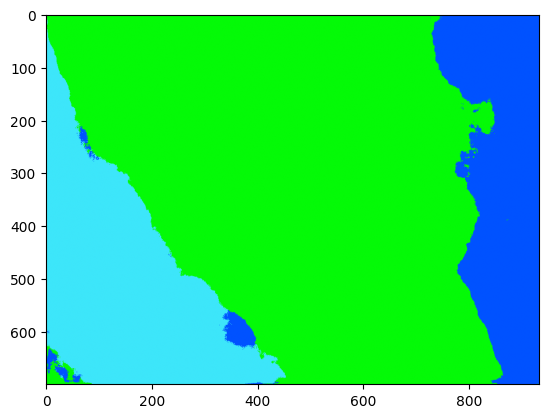

/outputs/airflow_data/floodnet/img-700/6927.jpg /outputs/airflow_data/outputs/6927.png
1 torch.Size([700, 933]) tensor(5) /outputs/airflow_data/floodnet/img-700/6927.jpg


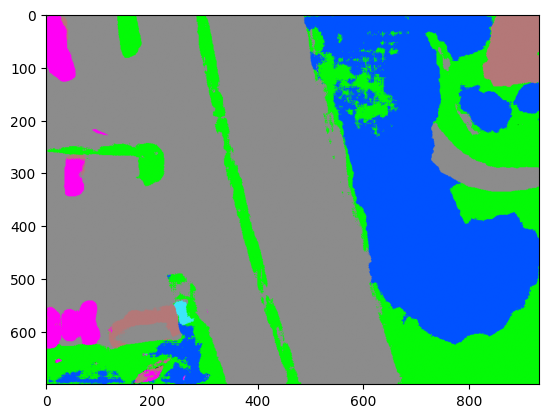

/outputs/airflow_data/floodnet/img-700/9018.jpg /outputs/airflow_data/outputs/9018.png
2 torch.Size([700, 933]) tensor(6) /outputs/airflow_data/floodnet/img-700/9018.jpg


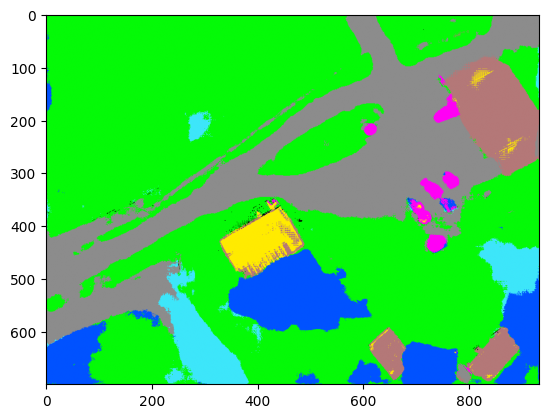

/outputs/airflow_data/floodnet/img-700/8194.jpg /outputs/airflow_data/outputs/8194.png
3 torch.Size([700, 933]) tensor(7) /outputs/airflow_data/floodnet/img-700/8194.jpg


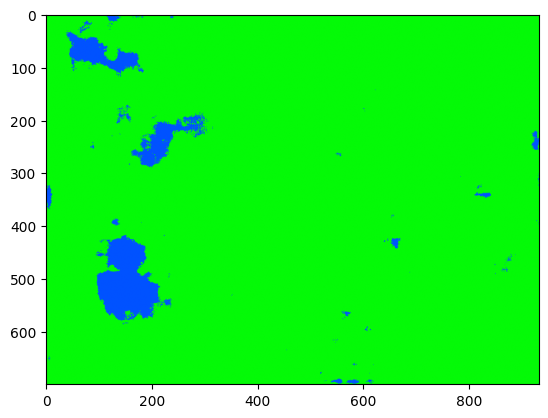

In [ ]:
torch.cuda.empty_cache()

# Print initial memory
tools.memprint("Before loading batch:")

start = time.time()
model.eval()
with torch.no_grad():
    
    batch, indexes = next(iterator)
    print(batch.shape, indexes.shape)
    batch = batch.to(device)
    output = model(batch)
    print('interval', time.time() - start)
    tools.memprint("After loading 1 batch:")
    pred = train_utils.get_predictions(output)

    for i, t in enumerate(pred):
        path = infererence_dataset.imgs[indexes[i]]
        out_path = output_folder / path.with_suffix('.png').name
        print(path, out_path)
        
        print(i, t.shape, indexes[i], infererence_dataset.imgs[indexes[i]])
        save_segmentation_mask(t, out_path)
        imgt.view_np(imgt.label_to_np(t.cpu()))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0609536799387485e-08..1.000000021978234].


Text(0.5, 1.0, 'Image')

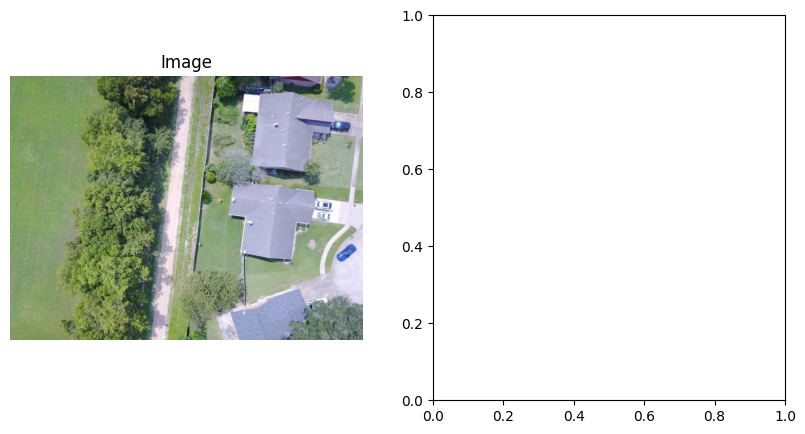

In [ ]:
# import matplotlib.pyplot as plt
# n=2
# view_img = imgt.img_to_np(infererence_dataset[n][0])

# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(view_img)
# axes[0].axis('off')
# axes[0].set_title('Image')

In [36]:
for i, batch in enumerate(dataloader):
    print(f"Processing batch {i}")
    print(batch.shape)


Processing batch 0


AttributeError: 'list' object has no attribute 'shape'

In [15]:
import numpy as np
def load_png_as_tensor(path):
    img = Image.open(path).convert('L')  # 'L' = 8-bit grayscale
    tensor = torch.from_numpy(np.array(img)).long()  # dtype: int64 (label class)
    return tensor  # shape: (H, W)

In [19]:
tensore = load_png_as_tensor('/outputs/airflow_data/outputs/7794.png')

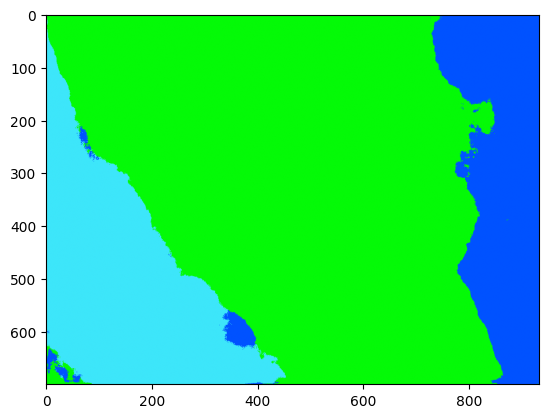

In [20]:
ttt = imgt.label_to_np(tensore)
imgt.view_np(ttt)